In [2]:
!pip install transformers torch peft accelerate langgraph huggingface_hub -q

In [3]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, END
from peft import AutoPeftModelForSequenceClassification
from transformers import AutoTokenizer, pipeline
import os

In [ ]:
# loading models
classifier = pipeline(
    "text-classification",
    model="myselfmankar/distilbert-base-sst2-lora",
    return_all_scores=True # Needed to get confidence
)
LABEL_MAP = {"LABEL_0": "Negative", "LABEL_1": "Positive"}

fallback_classifier = pipeline(
    "zero-shot-classification", # Changed to zero-shot-classification pipeline
    model="facebook/bart-large-mnli",
    return_all_scores=True
)

In [30]:
class GraphState(TypedDict):
  input_text: str
  prediction: Optional[str]
  confidence: Optional[float]
  final_decision: Optional[str]
  fallback_invoked: bool

In [31]:
def run_inference(state: GraphState):
    print("\n--- INFERENCE ---")
    input_text = state['input_text']
    results = classifier(input_text)[0]
    top_prediction = max(results, key=lambda x: x['score'])
    prediction = LABEL_MAP[top_prediction['label']]
    confidence = top_prediction['score']
    print(f"  Prediction: '{prediction}' | Confidence: {confidence:.2%}")
    return {"prediction": prediction, "confidence": confidence, "fallback_invoked": False}


def check_confidence(state: GraphState):
    print("\n--- CONFIDENCE CHECK ---")
    confidence_threshold = 0.90  # Let's use a higher threshold for a better demo

    if state['confidence'] < confidence_threshold:
        print(f"  Confidence {state['confidence']:.2%} is below threshold. Triggering fallback.")
        return "ask_user"
    else:
        print(f"  Confidence {state['confidence']:.2%} is high. Accepting prediction.")
        return "accept_prediction"


def set_final_decision(state: GraphState):
    print("\n--- ACCEPTING ---")
    print("  Confidence is high. Final decision matches model prediction.")
    final_decision = state['prediction']
    return {"final_decision": final_decision}

In [32]:
#Fallback using Human-Verification.

def run_fallback_with_human_in_loop(state: GraphState):
    print("\n--- FALLBACK ---")
    question = f"  The model is not confident in its prediction of '{state['prediction']}'.\n  Was your review negative? (yes/no): "

    while True:
        user_response = input(question).strip().lower()
        if user_response in ["yes", "no"]:
            break
        print("  Invalid input. Please enter 'yes' or 'no'.")

    final_decision = "Negative" if user_response == "yes" else "Positive"

    print(f"  User clarified. Final Decision: {final_decision}")
    return {"final_decision": final_decision, "fallback_invoked": True}



In [33]:
def run_fallback_with_zero_shot(state: GraphState) -> dict:
    print("\n--- FALLBACK (Zero-Shot Model) ---")
    print("  Primary model confidence was low. Consulting backup model...")
    input_text = state['input_text']

    # The candidate labels we want the zero-shot model to choose from.
    candidate_labels = ["Positive", "Negative"]

    # The zero-shot pipeline returns one dictionary.
    # The results are already sorted by score.
    result = fallback_classifier(input_text, candidate_labels=candidate_labels)
    final_decision = result['labels'][0]
    confidence = result['scores'][0]

    print(f"  Backup Model Prediction: '{final_decision}' | Confidence: {confidence:.2%}")

    return {
        "final_decision": final_decision,
        "fallback_invoked": True
    }

In [34]:
# --- Assemble the Graph (Modern Syntax) ---
workflow = StateGraph(GraphState)
workflow.add_node("inference", run_inference)
workflow.add_node("fallback", run_fallback_with_zero_shot)
workflow.add_node("accept", set_final_decision)
workflow.set_entry_point("inference")
workflow.add_conditional_edges(
    "inference",
    check_confidence,
    {
        "ask_user": "fallback",
        "accept_prediction": "accept",
    }
)

workflow.add_edge("fallback", END)
workflow.add_edge("accept", END)

app = workflow.compile()

In [ ]:
print("Self-Healing Classification DAG")
# print("Enter your movie review, or type 'quit' to exit.")

while True:
    print("Enter your movie review, or type 'quit' to exit.")
    user_input = input("\nInput: ")
    if user_input.lower() == 'quit':
        break

    # Run the graph
    final_state = app.invoke({"input_text": user_input})

    print("\n" + "="*40)
    print("--- FINAL OUTPUT ---")
    print(f"Reviewed Text: '{final_state['input_text']}'")
    print(f"Final Label: {final_state['final_decision']}")
    if final_state['fallback_invoked']:
        print("Note: This decision was corrected via user clarification.")
    print("="*40)

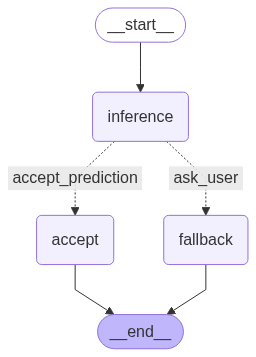

In [39]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))